# Sentiment Analysis of Reddit Comments

In [30]:
import openai
from openai.error import APIConnectionError, APIError, RateLimitError
from typing import List, Dict, Generator, Optional

import tiktoken
import pandas as pd
from dotenv import load_dotenv
import sys

import re
import random
import time
import praw
import os

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [31]:
model = "gpt-3.5-turbo"
load_dotenv("../.env")

openai.api_key = os.environ["OPENAI_API_KEY"]

reddit = praw.Reddit(
    client_id=os.environ["REDDIT_CLIENT_ID"],
    client_secret=os.environ["REDDIT_CLIENT_SECRET"],
    user_agent=f"script:test:0.0.1 (by u/yourusername)",
)

In [32]:
# https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

def num_tokens_from_messages(messages, model):
    """Returns the number of tokens used by a list of messages."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")
    if model == "gpt-3.5-turbo":
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0301")
    elif model == "gpt-4":
        return num_tokens_from_messages(messages, model="gpt-4-0314")
    elif model == "gpt-3.5-turbo-0301":
        tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
        tokens_per_name = -1  # if there's a name, the role is omitted
    elif model == "gpt-4-0314":
        tokens_per_message = 3
        tokens_per_name = 1
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens."""
        )
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens

## Getting Reddit Comments

In [33]:
DF_COLUMNS = ["subreddit", "submission_id", "score", "comment_body"]
filename, subreddits = "cities.csv", [
    "NYC",
    "Seattle",
    "LosAngeles",
    "Chicago",
    "Austin",
    "Portland",
    "SanFrancisco",
    "Boston",
    "Houston",
    "Atlanta",
    "Philadelphia",
    "Denver",
    "SeattleWa",
    "Dallas",
    "WashingtonDC",
    "SanDiego",
    "Pittsburgh",
    "Phoenix",
    "Minneapolis",
    "Orlando",
    "Nashville",
    "StLouis",
    "SaltLakeCity",
    "Columbus",
    "Raleigh",
]

# OTHER POTENTIAL SUBREDDITS TO TRY:
# filename, subreddits = "iphone_v_android.csv", ["iphone", "Android"]
# filename, subreddits = "startrek_v_starwars.csv", ["startrek", "StarWars"]
# filename, subreddits = "epl_top_8.csv", ["reddevils", "LiverpoolFC", "chelseafc", "Gunners", "coys", "MCFC", "Everton", "NUFC"]


In [34]:
# Utility functions for fetching comments from submissions
def comment_generator(submission) -> Generator:
    # Do not bother expanding MoreComments (follow-links)
    for comment in submission.comments.list():
        if hasattr(comment, "body") and comment.body != "[deleted]" and comment.body != "[removed]":
            yield (comment)

In [35]:
def collect_comments(
    filename: str,
    target_comments_per_subreddit: int,
    max_comments_per_submission: int,
    max_comment_length: int,
    reddit: praw.Reddit,
) -> pd.DataFrame:
    """
    Collect comments from the top submissions in each subreddit.

    Cache results at cache_filename.

    Return a dataframe with columns: subreddit, submission_id, score, comment_body
    """
    try:
        df = pd.read_csv(filename, index_col="id")
        assert df.columns.tolist() == DF_COLUMNS
    except FileNotFoundError:
        df = pd.DataFrame(columns=DF_COLUMNS)

    # dict like {comment_id -> {column -> value}}
    records = df.to_dict(orient="index")

    for subreddit_index, subreddit_name in enumerate(subreddits):
        print(f"Processing Subreddit: {subreddit_name}")

        processed_comments_for_subreddit = len(df[df["subreddit"] == subreddit_name])

        if processed_comments_for_subreddit >= target_comments_per_subreddit:
            print(f"Enough comments fetched for {subreddit_name}, continuing to next subreddit.")
            continue

        # `top`` is a generator, grab submissions until we break (within this loop).
        for submission in reddit.subreddit(subreddit_name).top(time_filter="month"):
            if processed_comments_for_subreddit >= target_comments_per_subreddit:
                break

            # The number of comments that we already have for this subreddit
            processed_comments_for_submission = len(df[df["submission_id"] == submission.id])

            for comment in comment_generator(submission):
                if processed_comments_for_submission >= max_comments_per_submission or processed_comments_for_subreddit >= target_comments_per_subreddit:
                    break

                if comment.id in records:
                    print(f"Skipping comment {subreddit_name}-{submission.id}-{comment.id} because we already have it")
                    continue

                body = comment.body[:max_comment_length].strip()
                records[comment.id] = {"subreddit": subreddit_name, "submission_id": submission.id, "comment_body": body}

                processed_comments_for_subreddit += 1
                processed_comments_for_submission += 1

            # Once per post write to disk.
            print(f"CSV rewritten with {len(records)} rows.\n")
            df = pd.DataFrame.from_dict(records, orient="index", columns=DF_COLUMNS)
            df.to_csv(filename, index_label="id")

    print("Completed.")
    return df

## Sentiment Analysis on Comments

In [36]:

MAX_ATTEMPTS = 3

def generate_prompt_messages(s: str) -> List[Dict]:
    return [
        {
            "role": "user",
            "content": """
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

The traffic is quite annoying.
""".strip(),
        },
        {"role": "assistant", "content": "-0.75"},
        {
            "role": "user",
            "content": """
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

The library is downtown.
""".strip(),
        },
        {"role": "assistant", "content": "0.0"},
        {
            "role": "user",
            "content": """
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

Even though it's humid, I really love the summertime. Everything is so green and the sun is out all the time.
""".strip(),
        },
        {"role": "assistant", "content": "0.8"},
        {
            "role": "user",
            "content": f"""
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

{s}
""".strip(),
        },
    ]


In [37]:
class UnscorableCommentError(Exception):
    pass


from tenacity import retry, wait_random_exponential, retry_if_exception_type, stop_after_attempt


@retry(
    wait=wait_random_exponential(multiplier=1, max=30),
    stop=stop_after_attempt(3),
    retry=retry_if_exception_type(UnscorableCommentError) | retry_if_exception_type(APIConnectionError) | retry_if_exception_type(APIError) | retry_if_exception_type(RateLimitError),
    reraise=True,  # Reraise the last exception
)
def score_sentiment(s: str, model: str) -> float:
    messages = generate_prompt_messages(s)
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
    )
    score_response = response.choices[0].message.to_dict()["content"].strip()
    # This will raise an Attribute Error if the regular expression doesn't match
    try:
        return float(re.search(r"([-+]?\d*\.?\d+)", score_response).group(1))
    except AttributeError:
        raise UnscorableCommentError(f"Could not score comment: {s}")

In [38]:
def estimate_cost_to_score_comments(df, model) -> float:
    """Estimate the number of tokens in a dataframe's comment_body column"""
    num_tokens = 0
    for comment in df["comment_body"]:
        num_tokens += num_tokens_from_messages(generate_prompt_messages(comment), model)
    return num_tokens * (0.002 / 1000)

In [39]:
def score_sentiments(filename: str, model: str) -> pd.DataFrame:
    """
    Score sentiments contained in comments in filename.
    """
    df = pd.read_csv(filename, index_col="id")
    assert df.columns.tolist() == DF_COLUMNS

    print(f"Scoring {len(df)} comments will cost approximately ${estimate_cost_to_score_comments(df, model):.2f}.")
    records = df.to_dict(orient="index")

    for index, item in enumerate(records.items()):
        comment_id, comment = item

        if not pd.isna(comment["score"]):
            print(f"{comment_id} was already scored. Skipping.")
            continue

        body = comment["comment_body"]
        try:
            score = score_sentiment(body, model=model)
        except UnscorableCommentError:
            # The score_sentiment method will retry 3 times before letting this error pass through.
            # If it does, we will consider this comment un-processable and skip it.
            # For other errors, such as APIConnectionError, we will fail completely and let the user know.
            continue
        print(
            f"""
            {comment_id} - ({index + 1} of {len(records)} Comments)
            Body: {body[:80]}
            Score: {score}""".strip()
        )

        records[comment_id]["score"] = score
        df = pd.DataFrame.from_dict(records, orient="index", columns=DF_COLUMNS)
        df.to_csv(filename, index_label="id")

    print("Scoring completed.")
    return df

## Plotting Sentiment

In [40]:
def get_avg_scores_sorted(df):
    avg_scores = df.groupby("subreddit")["score"].mean().reset_index()
    avg_scores = avg_scores.sort_values("score", ascending=True)
    return avg_scores

In [41]:
# Define our plotting function

# https://seaborn.pydata.org/examples/kde_ridgeplot.html
def get_avg_score_by_subreddit(dataframe):
    """
    Given a pandas DataFrame with columns "subreddit" and "score", returns a new DataFrame
    with the average score and standard deviation for each subreddit.
    """
    # Group by subreddit and calculate the mean and standard deviation for each group
    subreddit_stats = dataframe.groupby("subreddit")["score"].agg(["mean", "std"])

    # Rename columns to indicate that they represent the mean and standard deviation
    subreddit_stats.columns = ["mean_score", "standard_deviation"]

    subreddit_stats = subreddit_stats.sort_values("mean_score", ascending=True)

    # Return the new DataFrame
    return subreddit_stats


def plot_sentiments(df):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Create the data
    df_scores = df[["score", "subreddit"]]

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-0.25, light=0.7)
    g = sns.FacetGrid(df_scores, row="subreddit", row_order=get_avg_score_by_subreddit(df_scores).index.to_list(), hue="subreddit", aspect=15, height=0.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "score", bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "score", clip_on=False, color="w", lw=2, bw_adjust=0.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

    g.map(label, "score")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # display(g.fig)

## Run Everything!

In [42]:
NUM_SUBREDDITS = len(subreddits)
TARGET_COMMENTS_PER_SUBREDDIT = 50
MAX_COMMENTS_PER_SUBMISSION = 10
MAX_COMMENT_LENGTH = 2000

collect_comments(
    filename=filename,
    target_comments_per_subreddit=TARGET_COMMENTS_PER_SUBREDDIT,
    max_comments_per_submission=MAX_COMMENTS_PER_SUBMISSION,
    max_comment_length=MAX_COMMENT_LENGTH,
    reddit=reddit,
)

Processing Subreddit: NYC
CSV rewritten with 10 rows.

CSV rewritten with 20 rows.

CSV rewritten with 30 rows.

CSV rewritten with 40 rows.

CSV rewritten with 50 rows.

Processing Subreddit: Seattle
CSV rewritten with 60 rows.

CSV rewritten with 70 rows.

CSV rewritten with 80 rows.

CSV rewritten with 90 rows.

CSV rewritten with 100 rows.

Processing Subreddit: LosAngeles
CSV rewritten with 110 rows.

CSV rewritten with 120 rows.

CSV rewritten with 130 rows.

CSV rewritten with 140 rows.

CSV rewritten with 150 rows.

Processing Subreddit: Chicago
CSV rewritten with 160 rows.

CSV rewritten with 170 rows.

CSV rewritten with 180 rows.

CSV rewritten with 190 rows.

CSV rewritten with 200 rows.

Processing Subreddit: Austin
CSV rewritten with 210 rows.

CSV rewritten with 220 rows.

CSV rewritten with 230 rows.

CSV rewritten with 240 rows.

CSV rewritten with 250 rows.

Processing Subreddit: Portland
CSV rewritten with 260 rows.

CSV rewritten with 270 rows.

CSV rewritten with 2

,subreddit,submission_id,score,comment_body
kemlfcw,NYC,18p7fdg,NaN,I used to go there many years ago and my pare...
kemsgoa,NYC,18p7fdg,NaN,This is the type of self-promotion that belong...
kemo1og,NYC,18p7fdg,NaN,Gotta take visitors into NYC on a flat-out tou...
kemw6hf,NYC,18p7fdg,NaN,I’ve travelled to your restaurant from Harlem ...
keo93dv,NYC,18p7fdg,NaN,"I run the only meat shop on Division Street, r..."
...,...,...,...,...
kcn5df4,Raleigh,18efsab,NaN,Geez some guy missed his rehearsal dinner beca...
kcn98qt,Raleigh,18efsab,NaN,If I remember right that place was a similar (...
kcnc7mv,Raleigh,18efsab,NaN,what was their health rating before this?
kcnhp69,Raleigh,18efsab,NaN,If you walk into a restaurant that sells raw f...


In [43]:
df = score_sentiments(
    filename=filename,
    model=model,
)

Scoring 1250 comments will cost approximately $0.66.
kemlfcw - (1 of 1250 Comments)
            Body: I used to go there many years ago and  my parents would get me the noodles and w
            Score: 0.9
kemsgoa - (2 of 1250 Comments)
            Body: This is the type of self-promotion that belongs here and it warms my heart.  The
            Score: 0.9
kemo1og - (3 of 1250 Comments)
            Body: Gotta take visitors into NYC on a flat-out tourist crawl after New Years and I w
            Score: 0.6
kemw6hf - (4 of 1250 Comments)
            Body: I’ve travelled to your restaurant from Harlem specifically for the Peanut Noodle
            Score: 0.9
keo93dv - (5 of 1250 Comments)
            Body: I run the only meat shop on Division Street, right behind you. 

Our prices are 
            Score: 0.4
kenbkv9 - (6 of 1250 Comments)
            Body: Ok I just ordered my noodles. Woman behind counter is rolling dumplings.
EDIT: D
            Score: 0.9
kemn6n3 - (7 of 1250 Comments

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


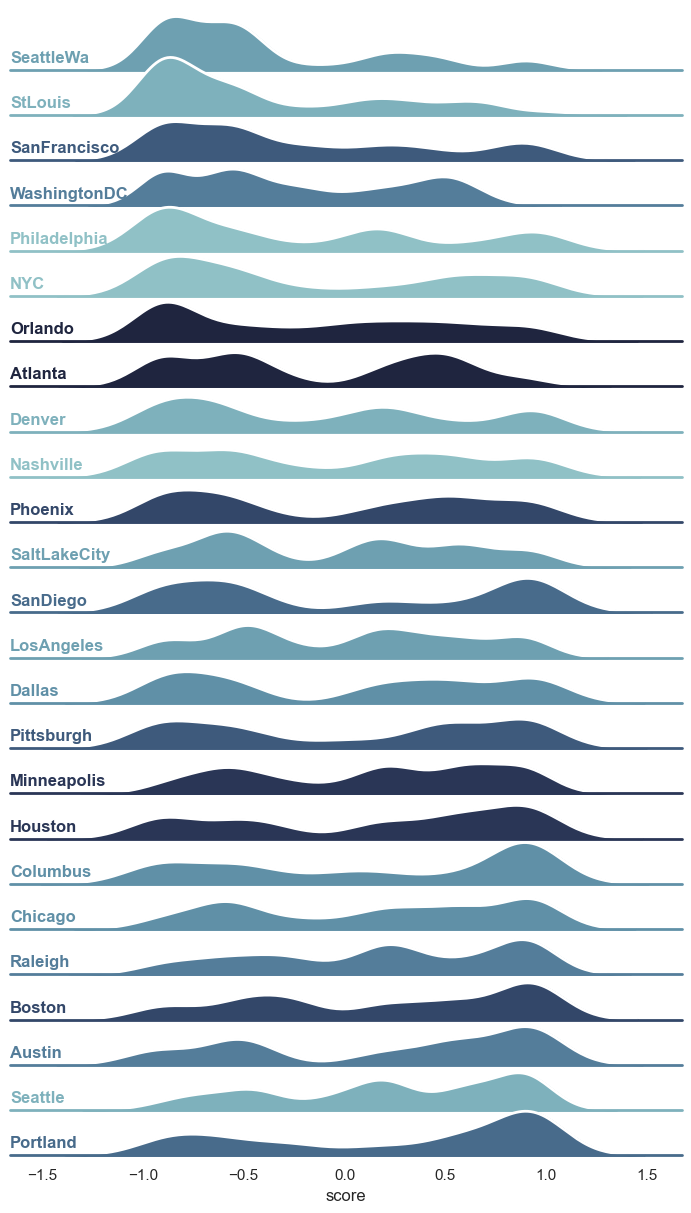

In [44]:
plot_sentiments(df)